In [10]:
import numpy as np
import math, json
from rdp import rdp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
import tqdm.notebook as tq
import pickle
from collections import defaultdict
import cairosvg
from PIL import Image,ImageDraw
import glob
import os 
import re
import svgwrite

In [2]:
def get_bounds(data):
    minx, miny = 600, 600  
    maxx, maxy = 0, 0
    
    for i, (x, y, z) in enumerate(data): 
        if minx > x:
            minx = x
        if miny > y:
            miny = y 

        if maxx < x:
            maxx = x
        if maxy < y:
            maxy = y 
    return minx, maxx, miny, maxy

In [11]:
def convert_3d(drawing, return_flag = False, threshold=10):
    out = []
    corrupted = False
    for item in drawing:
        char = list(item.keys())[0]
        stroke = item[char]
        if len(stroke) == 1:
            x, y = stroke[0]
            out.append([x, y, 0])
            out.append([x+5, y+5, 1])
            continue
        segment = []
        for i, point in enumerate(stroke):
            x, y = point 
            if i == len(stroke) - 1:
                segment.append([x, y, 1])
            else:
                segment.append([x, y, 0])
        
        start = 0 
        for i, point in enumerate(segment):
            if i < len(segment) -1:
                x, y, _ = point
                next_x, next_y, _ = segment[i+1]
                if any((
                    abs(x-next_x)>threshold,
                    abs(y-next_y>threshold),
                )):
                    corrupted=True
                    start = i +1
        
        out += segment[start:]
    if return_flag:
        return out, corrupted
    return out

In [12]:
def make_square(im, min_size=256, fill_color=(255, 255, 255)):
    x, y = im.size
    size = max(min_size, x, y)
    new_im = Image.new('RGBA', (size, size), fill_color)
    new_im.paste(im, (int((size - x) / 2), int((size - y) / 2)))
    return new_im

In [13]:
def draw_strokes(data, factor=1, svg_filename = 'tmp/sample.svg', stroke_width = 3, square = False, return_res = False):
    min_x, max_x, min_y, max_y = get_bounds(data)
    dims = (50 + max_x - min_x, 50 + max_y - min_y)
    dwg = svgwrite.Drawing(svg_filename, size = dims)
    dwg.add(dwg.rect(insert=(0, 0), size=dims,fill='white'))
    lift_pen = 1
    abs_x = 25 - min_x 
    abs_y = 25 - min_y
    p = "M%s,%s " % (abs_x, abs_y)
    command = "M"
    for i in range(len(data)):
        if (lift_pen == 1):
            command = "M"
        elif (command != "L"):
            command = "L"
        else:
            command = ""
        x = float(data[i][0]) - min_x
        y = float(data[i][1]) - min_y
        lift_pen = data[i][2]
        p += command+str(x)+" "+str(y)+" "
    the_color = "black"
    
    dwg.add(dwg.path(p).stroke(the_color,stroke_width).fill("none"))
    dwg.save()
    cairosvg.svg2png(url="tmp/sample.svg", write_to="tmp/sample.png")
    img = Image.open('tmp/sample.png')
    if square:
        img = make_square(img)
    if return_res:
        return img, dims 
    else:
        return img

In [14]:
npy_files = glob.glob('server/larger_data/*')
file = np.random.choice(npy_files)

In [15]:
file = 'server/larger_data/1فسبحان الله حين تمسون وحين تصبحون.json'

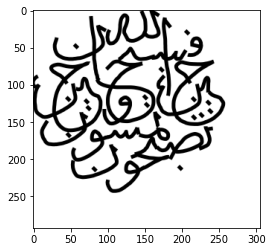

In [16]:
drawing = json.load(open(file))
data1, flag = convert_3d(drawing, return_flag=True, threshold=50)
plt.imshow(draw_strokes(data1, stroke_width = 5))
plt.show()

In [22]:
def apply_rdb(drawing, verbose = 0):
    new_drawing = []
    total_prev_strokes = 0
    total_post_strokes = 0
    for item in drawing:
        char = list(item.keys())[0]
        stroke = item[char]
        processed_stroke = []
        if len(stroke):
            if verbose:
                print('processing ', char)
            post_stroke = rdp(stroke, epsilon = 2.0)
            total_post_strokes += len(post_stroke)
            total_prev_strokes += len(stroke)
        new_drawing.append({char:post_stroke})
    if verbose:
        print('reduced from ', total_prev_strokes, ' to ', total_post_strokes)
    return new_drawing

In [23]:
#https:#jrgraphix.net/r/Unicode/0600-06FF
map_chars = {
    "\u0623":["\u0621", "\u0627"], # أ
    "\u0622":["\u0605", "\u0627"], # آ
    "\u0625":["\u0627", "\u0621"], # إ
    "\u0628":["\u066E", "."], # ب
    "\u062A":[".", ".", "\u066E"], # ت
    "\u062B":[".", ".", ".", "\u066E"], # ث 
    "\u062C":["\u062D", "."], # ج
    "\u062E":[".", "\u062D"], # خ
    "\u0630":[".", "\u062F"], # ذ
    "\u0632":[".", "\u0631"], # ز
    "\u0634":[".", ".", ".", "\u0633"], # ش
    "\u0636":[".", "\u0635"], # ض
    "\u0637":["\u0627", "\uFEBB"], # ط
    "\u0638":[".", "\u0627", "\uFEBB"], # ظ
    "\u063A":[".", "\u0639"], # غ
    "\u0641":[".", "\u066F"], # ف
    "\u0642":[".", ".", "\u066F"], # ق
    "\u06A4":[".", ".", ".", "\u066F"], # ڤ
    "\u0643":["\u0621", "\u0644"], # ك
    "\u0646":[".", "\u06BA"], # ن
    "\u0624":["\u0621", "\u0648"], # ؤ
    "\u064A":["\u0649", ".", "."], #ي
    "\u0626":["\u0621", "\u0649"], #ئ
    "\u0629":[".", ".", "\u0647"], #ه
}

In [41]:
def preprocess(text):
    char_comps = []
    
    diacritics = "[ًٌٍَُِّْ]"
    numbers = '0123456789'
    for diac in diacritics: 
        text = text.replace(diac, '')

    for num in numbers: 
        text = text.replace(num, '')
    
    outText = ""
    
    for i in range(len(text)):
    
        if (text[i] == " "):
            continue
    
        if text[i] in map_chars:
            if (i < len(text) - 1 and text[i] == "\u0643"):
                if text[i+1] != ' ':
                    char_comps.append({text[i] : '\uFEDB'})
                    outText += '\uFEDB'
                else:
                    char_comps.append({text[i] : map_chars[text[i]]})
                    outText += ''.join(map_chars[text[i]])
            else:
                char_comps.append({text[i] : map_chars[text[i]]})
                outText += ''.join(map_chars[text[i]])
        else:
                char_comps.append({text[i] : text[i]})
                outText += text[i]

    return char_comps, outText

In [42]:
def concatenate(images, mode='h', margin=10):
    widths, heights = zip(*(i.size for i in images))
    if mode =='h':
        total_width = sum(widths)
        max_height = max(heights)

        new_im = Image.new('RGB', (total_width, max_height), (255, 255, 255))

        x_offset = 0
        for im in images[::-1]:
            new_im.paste(im, (x_offset,0))
            x_offset += im.size[0]
    elif mode == 'v':    
        total_height = sum(heights)
        max_width = max(widths)

        new_im = Image.new('RGB', (max_width, total_height+margin*(len(images)-1)), (255, 255, 255))
        draw = ImageDraw.Draw(new_im)
        y_offset = 0
        for im in images:
            new_im.paste(im, (0,y_offset+margin))
            y_offset += im.size[1]
            draw.line((0,y_offset+margin-5, max_width,y_offset+margin-5), fill=(0, 0, 0), width=3)
    return new_im

In [43]:
def generate_characters(file):
    char_drawings = []
    annot = file.split('/')[-1][:-5]
    char_comps = preprocess(annot)
    drawing = json.load(open(file))
    new_drawing = apply_rdb(drawing, verbose = 0)
    i = 0 
    for comp in char_comps:
        char = list(comp.keys())[0]
        j = i + len(comp[char])
        char_drawings.append({char:new_drawing[i:j]})
        i = j 
    return char_drawings

In [53]:
import glob
npy_files = glob.glob('server/larger_data/*')
file = np.random.choice(npy_files)

In [57]:
len(glob.glob('server/larger_data/*'))

1800

In [91]:
wrong_annotations = []
for file in glob.glob('server/data/*'):
    drawing = json.load(open(file))
    stroke_chars = ''
    _, original_stroke_chars = preprocess(file.split("/")[-1][:-5].split('_')[-1])
    for comp in drawing:
        stroke_chars += list(comp.keys())[0]
    if stroke_chars != original_stroke_chars:
        print(file)
        print(stroke_chars)
        print(original_stroke_chars)
        wrong_annotations.append(file)
        data1, flag = convert_3d(drawing, return_flag=True, threshold=50)
        plt.imshow(draw_strokes(data1, stroke_width = 5))
        plt.show()

In [95]:
len(glob.glob('server/larger_data/*') + glob.glob('server/data/*'))

2417

In [117]:
len(glob.glob('server/static/processed_larger_images/*') + glob.glob('server/static/images/*'))

2500

In [118]:
wrong_annotations = []
for file in glob.glob('server/larger_data/*'):
    drawing = json.load(open(file))
    stroke_chars = ''
    _, original_stroke_chars = preprocess(file.split("/")[-1][:-5])
    for comp in drawing:
        stroke_chars += list(comp.keys())[0]
    if stroke_chars != original_stroke_chars:
        print(file)
        print(stroke_chars)
        print(original_stroke_chars)
        wrong_annotations.append(file)
        data1, flag = convert_3d(drawing, return_flag=True, threshold=50)
        plt.imshow(draw_strokes(data1, stroke_width = 5))
        plt.show()

In [119]:
wrong_annotations

[]

In [71]:
import os
import shutil

for file in wrong_annotations:
    file_name = file.split('/')[-1][:-5]
    os.remove(file)  
    shutil.move(f'server/static/processed_larger_images/{file_name}.jpg', f'server/static/larger_images/{file_name}.jpg')

In [90]:
import os
import shutil

for file in wrong_annotations:
    file_name = file.split("/")[-1][:-5]
    new_image_name = file.split("/")[-1][:-5].split('_')[-1]
    try:
        os.remove(file)  
        shutil.move(f'server/static/images/{file_name}.jpg', f'server/static/larger_images/{new_image_name}.jpg')
    except:
        continue

In [109]:
!ls server/larger_data/ | wc -l

1818
